# Basic Settings

In [42]:
import random
import pandas as pd
import numpy as np
import os
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime

import warnings
warnings.filterwarnings(action='ignore') 

In [43]:
CFG = {
    'RUN_TYPE': 'INFERENCE',
    'CLF_PATHS': './cnn_classifier.pth',
    'SEED': 42,
}

In [44]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [45]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Prepare Dataset

In [46]:
simulation_sem_paths = sorted(glob.glob('./processed_data/simulation/SEM/*.png'))
simulation_depth_paths = sorted(glob.glob('./processed_data/simulation/Depth/*.png'))

df_simul = pd.DataFrame({'SEM':simulation_sem_paths, 'depth':simulation_depth_paths})
df_simul['case'] = df_simul['SEM'].apply(lambda x: int(x[36]))

In [47]:
df_simul

,SEM,depth,case
0,./processed_data/simulation/SEM\SEM_1_00000.png,./processed_data/simulation/Depth\Depth_1_0000...,1
1,./processed_data/simulation/SEM\SEM_1_00001.png,./processed_data/simulation/Depth\Depth_1_0000...,1
2,./processed_data/simulation/SEM\SEM_1_00002.png,./processed_data/simulation/Depth\Depth_1_0000...,1
3,./processed_data/simulation/SEM\SEM_1_00003.png,./processed_data/simulation/Depth\Depth_1_0000...,1
4,./processed_data/simulation/SEM\SEM_1_00004.png,./processed_data/simulation/Depth\Depth_1_0000...,1
...,...,...,...
86647,./processed_data/simulation/SEM\SEM_4_86647.png,./processed_data/simulation/Depth\Depth_4_8664...,4
86648,./processed_data/simulation/SEM\SEM_4_86648.png,./processed_data/simulation/Depth\Depth_4_8664...,4
86649,./processed_data/simulation/SEM\SEM_4_86649.png,./processed_data/simulation/Depth\Depth_4_8664...,4
86650,./processed_data/simulation/SEM\SEM_4_86650.png,./processed_data/simulation/Depth\Depth_4_8665...,4


In [48]:
class Clf_Dataset(Dataset):
  def __init__(self, sem_path_list):
    self.sem_path_list = sem_path_list
    
  def __len__(self):
    return len(self.sem_path_list)

  def __getitem__(self, idx):
    img = torch.Tensor(cv2.imread(self.sem_path_list[idx], cv2.IMREAD_GRAYSCALE))[None, :] / 255
    return img

# Case Classifier Model

In [49]:
!pip install timm

In [50]:
import timm # timm 설치 필요

class Case_Classifier(nn.Module):
    def __init__(self):
        super(Case_Classifier, self).__init__()
        self.model = timm.create_model('tf_efficientnet_b0_ns', pretrained = True, num_classes = 4, in_chans=1)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = self.model(x)
        return self.softmax(x)

# Do Case_classification

In [51]:
test_sem_path_list = sorted(glob.glob('./test/SEM/*.png'))

clf_set = Clf_Dataset(test_sem_path_list)
clf_loader = DataLoader(clf_set, batch_size=64, shuffle=False)

In [52]:
classifier = Case_Classifier().to(device).eval()
classifier.load_state_dict(torch.load(CFG['CLF_PATHS']))

<All keys matched successfully>

In [53]:
case_list = []
with torch.no_grad():
  for img in tqdm(iter(clf_loader)):
    img = img.to(device)
    preds = classifier(img).argmax(dim=1) + 1
    for pred in preds:
      case_list.append(pred.cpu().numpy())

df_test = pd.DataFrame({'path':test_sem_path_list, 'case':case_list})
del img
del preds
del clf_loader

100%|████████████████████████████████████████████████████████████████████████████████| 407/407 [00:10<00:00, 38.64it/s]


In [54]:
for i in range(1,5):
  print(len(df_test[df_test['case']==i]))

6508
6510
6503
6467


# Get similarity

In [55]:
class Similarity_simul_dataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img = torch.Tensor(cv2.imread(self.df.iloc[idx]['SEM'], cv2.IMREAD_GRAYSCALE))[None, :]
        avg = torch.mean(img)
        std = torch.std(img, unbiased=False)
        img = (img-avg) / std
        return img

class Similarity_test_dataset(Dataset):
  def __init__(self, df):
    self.df = df
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    sem_path = self.df.iloc[idx, 0]
    img = torch.Tensor(cv2.imread(sem_path, cv2.IMREAD_GRAYSCALE))[None, :]
    
    avg = torch.mean(img)
    std = torch.std(img, unbiased=False)
    img = (img-avg) / std

    return img

In [56]:
def shift_img(img, h_shift, w_shift):
  h_shifted_img = torch.zeros(img.shape)
  shifted_img = torch.zeros(img.shape)
  if h_shift >= 0:
    h_shifted_img[:, :, 0:72-h_shift, :] = img[:, :, h_shift:72, :]
    h_shifted_img[:, :, 72-h_shift:72, :] = img[:, :, :h_shift, :]
  else:
    h_shift *= -1
    h_shifted_img[:, :, h_shift:72, :] = img[:, :, 0:72-h_shift, :]
    h_shifted_img[:, :, :h_shift, :] = img[:, :, 72-h_shift:72, :]

  if w_shift <  0:
    w_shift *= -1
    shifted_img[:, :, :, 0:48-w_shift] = h_shifted_img[:, :, :, w_shift:48]
    shifted_img[:, :, :, 48-w_shift:48] = h_shifted_img[:, :, :, :w_shift]
  else:
    shifted_img[:, :, :, w_shift:48] = h_shifted_img[:, :, :, 0:48-w_shift]
    shifted_img[:, :, :, :w_shift] = h_shifted_img[:, :, :, 48-w_shift:48]
  
  return shifted_img


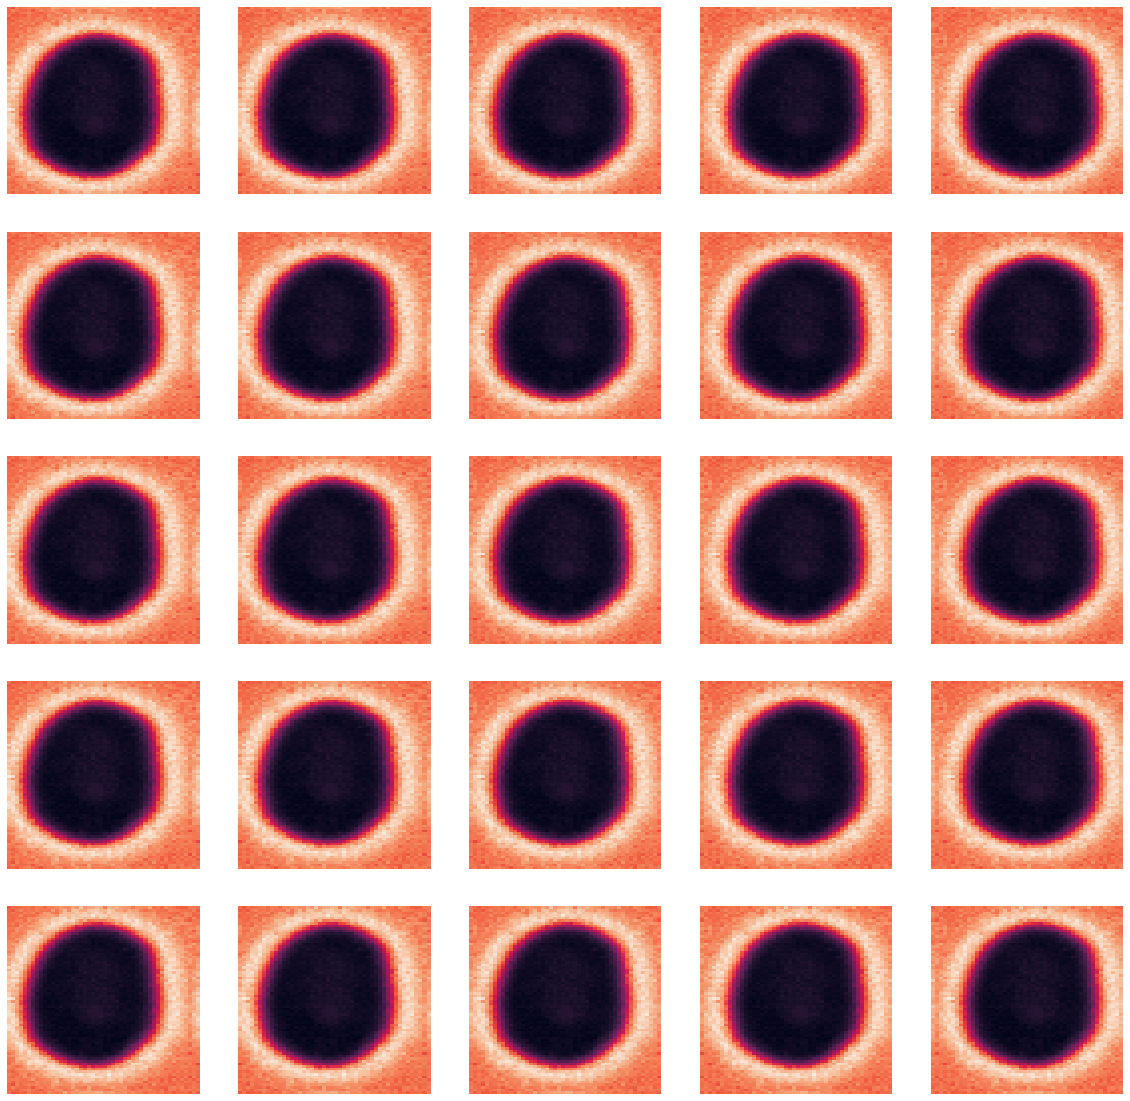

In [57]:
temp_simul = df_simul[df_simul['case']==1]
rn = np.random.randint(len(temp_simul))
img = torch.Tensor(cv2.imread(temp_simul.iloc[rn,0], cv2.IMREAD_GRAYSCALE))
n=2

fig, axes = plt.subplots((2*n+1),(2*n+1))
fig.set_size_inches(20,20)

for i in range(-n, n+1):
  for j in range(-n, n+1):
    sns.heatmap(shift_img(img[None, None,:], i, j).squeeze(), cbar=False, xticklabels=False, yticklabels=False, ax=axes[i+n, j+n])


In [ ]:
similarity_matrix = {1:None, 2:None, 3:None, 4:None}

w_max = 2
h_max = 2

with torch.no_grad():
  for case in range(1,5):
    print(f'calculating similarities for case_{case}')
    simul_set = Similarity_simul_dataset(df_simul[df_simul['case']==case])
    simul_loader = DataLoader(simul_set, batch_size=7000, shuffle=False)
    test_set = Similarity_test_dataset(df_test[df_test['case']==case])
    test_loader = DataLoader(test_set, batch_size=7000, shuffle=False)

    for h_shift in range(-h_max, h_max+1):
      for w_shift in range(-w_max, w_max+1):
        shift_similarity = None
        for test_sem in tqdm(test_loader):
          test_sem = test_sem.view(-1,3456).to(device)
          batch_similarity = None
          for simul_sem in simul_loader:
            simul_sem = shift_img(simul_sem, h_shift, w_shift).view(-1,3456).to(device)
            cos_similarity = torch.matmul(test_sem, simul_sem.T)
   
            if batch_similarity is None:
              batch_similarity = cos_similarity
            else:
              batch_similarity = torch.cat((batch_similarity, cos_similarity), dim=1)
             
          batch_similarity = torch.argmax(batch_similarity, dim=1)
  
          if shift_similarity is None:
            shift_similarity = batch_similarity
          else:
            shift_similarity = torch.cat((shift_similarity, batch_similarity), dim=0)

        if similarity_matrix[case] is None:
          similarity_matrix[case] = shift_similarity[None, :]
        else:
          similarity_matrix[case] = torch.cat((similarity_matrix[case], shift_similarity[None, :]), dim=0)
        print('similarity_matrix',similarity_matrix[case].shape )
    similarity_matrix[case] = similarity_matrix[case].cpu()
    print(f'case_{case} finished')
    print(similarity_matrix[case].shape)

In [59]:
for i in range(1,5):
  pd.DataFrame(similarity_matrix[i].numpy()).to_csv(f'shift_similarity_matrix_{i}.csv')

In [60]:
similarity_matrix[1].shape

torch.Size([49, 6508])

<AxesSubplot:>

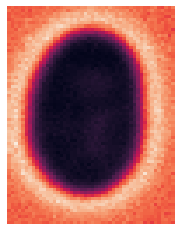

In [61]:
case=1
show_num = 5
temp_simul = df_simul[df_simul['case']==case]
temp_test = df_test[df_test['case']==case]
rn = np.random.randint(len(temp_test))
img = torch.Tensor(cv2.imread(temp_test.iloc[rn,0], cv2.IMREAD_GRAYSCALE))
std, mean = torch.std_mean(img, unbiased=False)
img = (img-mean) / std

fig = plt.figure(figsize=(3,4))
sns.heatmap(img, xticklabels=False, yticklabels=False, cbar=False)

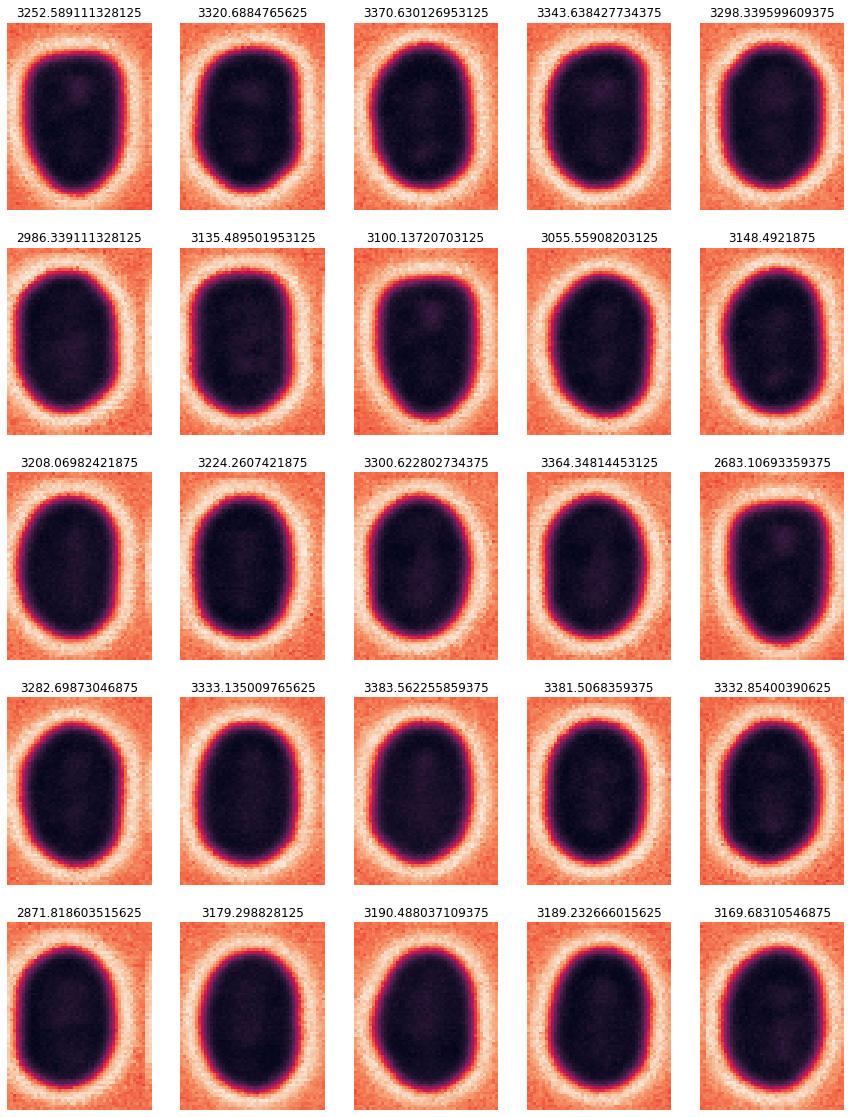

In [62]:
fig, axes = plt.subplots(show_num,show_num)
fig.set_size_inches(show_num*3, show_num*4)

for n in range(0, show_num):
  for j in range(0, show_num):
    similar_arg = similarity_matrix[case][(n)*show_num+j][rn]
    img_path =temp_simul.iloc[similar_arg.item()]['SEM']
    similar_img = torch.Tensor(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))
    std, mean = torch.std_mean(similar_img, unbiased=True)
    similar_img = (similar_img-mean) / std

    h_shift = j // 5 - 2
    w_shift = j % 5 - 2
    similar_img = shift_img(similar_img[None, None, :], h_shift, w_shift).squeeze()
    sns.heatmap(similar_img, ax=axes[n,j], xticklabels=False, yticklabels=False, cbar=False)

    similarity = torch.dot(img.view(-1), similar_img.view(-1))
    axes[n,j].set_title(f'{similarity}')

# Inference

In [63]:
similarity_matrix = {}
for i in range(1, 5):
  similarity_matrix[i] = pd.read_csv(f'./shift_similarity_matrix_{i}.csv', index_col=0).to_numpy()

h_max = 2
w_max = 2

In [64]:
result_name_list = []
result_list = []

for case in range(1, 5):
  print(f'case{case}')
  temp_test = df_test[df_test['case']==case]
  temp_simul = df_simul[df_simul['case']==case]
  for i in tqdm(range(len(temp_test))):
    img_path = temp_test.iloc[i,0]
    img = torch.Tensor(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)).view(-1)

    avg = torch.mean(img)
    std = torch.std(img, unbiased=False)
    img = (img-avg) / std

    similarity_list = []
    for j in range((2*h_max+1)*(2*w_max+1)):
      similar_arg = similarity_matrix[case][j][i]
      sim_img_path = temp_simul.iloc[similar_arg.item()]['SEM']
      similar_img = torch.Tensor(cv2.imread(sim_img_path, cv2.IMREAD_GRAYSCALE))
      
      std, mean = torch.std_mean(similar_img, unbiased=True)
      similar_img = (similar_img-mean) / std

      h_shift = j // (2*w_max+1) - h_max
      w_shift = j % (2*w_max+1) - w_max
      similar_img = shift_img(similar_img[None, None, :], h_shift, w_shift).cpu()
      similarity = torch.dot(img, similar_img.view(-1))
      similarity_list.append(similarity)

    #np argmax => top k
    best_shift = np.argmax(similarity_list)
    best_arg = similarity_matrix[case][best_shift][i].item()

    h_shift = best_shift // (2*w_max+1) - h_max
    w_shift = best_shift % (2*w_max+1) - w_max

    best_path = temp_simul.iloc[best_arg]['depth']

    pred = cv2.imread(best_path, cv2.IMREAD_GRAYSCALE)

    img_name = img_path.split('/')[-1]
    save_img_path = f'{img_name}'
    result_name_list.append(save_img_path)
    result_list.append(pred)

case1


100%|██████████████████████████████████████████████████████████████████████████████| 6508/6508 [02:09<00:00, 50.21it/s]


case2


100%|██████████████████████████████████████████████████████████████████████████████| 6510/6510 [02:09<00:00, 50.44it/s]


case3


100%|██████████████████████████████████████████████████████████████████████████████| 6503/6503 [02:08<00:00, 50.54it/s]


case4


100%|██████████████████████████████████████████████████████████████████████████████| 6467/6467 [02:07<00:00, 50.65it/s]


In [65]:
import zipfile
test_id = 'Submission_F3'

os.makedirs(f'./{test_id}/SEM', exist_ok=True)
os.chdir(f"./{test_id}")
sub_imgs = []
for path, pred_img in zip(result_name_list, result_list):
    cv2.imwrite(path, pred_img)
    sub_imgs.append(path[4:])

os.chdir(f"./SEM")
submission = zipfile.ZipFile(f"../{test_id}.zip", 'w')

for path in sub_imgs:
    submission.write(path)
submission.close()

os.chdir('../')
os.chdir('../')
os.getcwd()

'C:\\Users\\gosud\\Desktop\\program\\Deep_Learning\\samsung_final_run'

# Submit Submission_F.zip file in Submission_F folder!